# 1. Load from disk and upload to the Hub

## Setup

In [1]:
import os
import urllib
import zipfile

from detection_datasets import DetectionDataset

## Download the files

The files (images and annotations) are stored in S3, and the links for downloading them are provided in a [GitHub repository](https://github.com/cvdfoundation/fashionpedia).


The dataset is formatted in the [COCO format](https://cocodataset.org/#format-data).

Link for the `train` images:  
https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip    
Link for the `validation` images:   
https://s3.amazonaws.com/ifashionist-dataset/images/val_test2020.zip   

Link for the `train` annotations:   
https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json    
Link for the `validation` annotations:   
https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_val2020.json    

You may notice the the `test` split is absent: this is because the dataset was part of a Kaggle competition, where the submission are evaluate on a holdout test data that is not public. 
See notebook 2. to see how to create your custom splits nevertheless.

Let's first define some constants:

In [2]:
# Download from S3
RAW_TRAIN_IMAGES = 'https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip'
RAW_VAL_IMAGES = 'https://s3.amazonaws.com/ifashionist-dataset/images/val_test2020.zip'
RAW_TRAIN_ANNOTATIONS = 'https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json'
RAW_VAL_ANNOTATIONS = 'https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_val2020.json'

# to local disk
DATA_DIR = os.path.join(os.getcwd(), 'data')
TRAIN_ANNOTATIONS = 'train.json'
VAL_ANNOTATIONS = 'val.json'

And now download the images and annotations:

In [3]:
def download(url, target):
    """Download image and annotations."""
    
    # Images
    if url.split('.')[-1] == 'zip':
        path, _ = urllib.request.urlretrieve(url=url)
        with zipfile.ZipFile(path, "r") as f:
            f.extractall(target)
            
        os.remove(path)
    
    # Annotations
    else:
        urllib.request.urlretrieve(url=url, filename=target)


os.makedirs(DATA_DIR, exist_ok=True)

download(url=RAW_TRAIN_ANNOTATIONS, target=os.path.join(DATA_DIR, TRAIN_ANNOTATIONS))
download(url=RAW_VAL_ANNOTATIONS, target=os.path.join(DATA_DIR, VAL_ANNOTATIONS))

download(url=RAW_TRAIN_IMAGES, target=DATA_DIR)
download(url=RAW_VAL_IMAGES, target=DATA_DIR)

Here are the files and directories we have just downloaded:

In [4]:
os.listdir(DATA_DIR)

['test', 'train.json', 'train', 'val.json']

Note the the validation images are in the 'test' folder.

## Read the downloaded files

In [5]:
config = {
    'dataset_format': 'coco',                        # the format of the dataset on disk
    'path': DATA_DIR,                                # where the dataset is located
    'splits': {                                      # how to read the files
        'train': (TRAIN_ANNOTATIONS, 'train'),       # name of the split (annotation file, images directory)
        'val': (VAL_ANNOTATIONS, 'test'),               # the val directory get unziped in 'test'
    },
}

dd = DetectionDataset().from_disk(**config)

## Analyse the data

### DataFrame

Internally the data is stored in a Pandas DataFrame.

It can viewed grouped by image (the default):

In [6]:
dd.data      # This is the same as calling dd.get_data(index='image')

,image_path,width,height,split,bbox_id,bbox,category_id,category,area
image_id,,,,,,,,,
23,/Users/jeromeblin/self/blinjrm/detection-datas...,682,1024,train,"[150311, 150312, 150313, 150314]","[Bbox id 150311 [445.0, 910.0, 505.0, 983.0], ...","[23, 23, 33, 10]","[shoe, shoe, neckline, dress]","[1422, 843, 373, 56375]"
25,/Users/jeromeblin/self/blinjrm/detection-datas...,683,1024,train,"[158953, 158954, 158955, 158956, 158957, 15895...","[Bbox id 158953 [182.0, 220.0, 472.0, 647.0], ...","[2, 33, 31, 31, 13, 7, 22, 22, 23, 23]","[sweater, neckline, sleeve, sleeve, glasses, s...","[87267, 1220, 16895, 18541, 1468, 9360, 8629, ..."
26,/Users/jeromeblin/self/blinjrm/detection-datas...,1024,683,train,"[169196, 169197, 169198, 169199, 169200, 16920...","[Bbox id 169196 [441.0, 132.0, 499.0, 150.0], ...","[13, 29, 28, 32, 32, 31, 31, 0, 31, 31, 18, 4,...","[glasses, lapel, collar, pocket, pocket, sleev...","[587, 2922, 931, 262, 111, 1171, 540, 3981, 44..."
27,/Users/jeromeblin/self/blinjrm/detection-datas...,682,1024,train,"[167967, 167968, 167969, 167970, 167971, 16797...","[Bbox id 167967 [300.0, 421.0, 460.0, 846.0], ...","[6, 23, 23, 31, 31, 4, 1, 35, 32, 35, 35, 35, ...","[pants, shoe, shoe, sleeve, sleeve, jacket, to...","[44062, 2140, 2633, 9206, 5905, 44791, 12948, ..."
28,/Users/jeromeblin/self/blinjrm/detection-datas...,853,1024,train,"[168041, 168042, 168043, 168044, 168045, 16804...","[Bbox id 168041 [238.0, 309.0, 471.0, 1022.0],...","[10, 32, 35, 31, 4, 29, 33]","[dress, pocket, zipper, sleeve, jacket, lapel,...","[12132, 1548, 755, 43926, 178328, 9316, 136]"
...,...,...,...,...,...,...,...,...,...
50525,/Users/jeromeblin/self/blinjrm/detection-datas...,660,1024,train,"[82929, 82930, 82931, 82932, 82933, 82934, 82935]","[Bbox id 82929 [419.0, 214.0, 576.0, 637.0], B...","[31, 31, 33, 2, 15, 8, 32]","[sleeve, sleeve, neckline, sweater, headband, ...","[39360, 26851, 2431, 262021, 1422, 34694, 294]"
50526,/Users/jeromeblin/self/blinjrm/detection-datas...,682,1024,train,"[82936, 82937, 82938, 82939, 82940]","[Bbox id 82936 [168.0, 846.0, 504.0, 1022.0], ...","[6, 1, 33, 32, 32]","[pants, top, t-shirt, sweatshirt, neckline, po...","[49375, 151458, 4122, 993, 371]"
50528,/Users/jeromeblin/self/blinjrm/detection-datas...,682,1024,train,"[177641, 177642, 177643, 177644, 177645, 177646]","[Bbox id 177641 [195.0, 256.0, 408.0, 725.0], ...","[10, 33, 31, 31, 23, 23]","[dress, neckline, sleeve, sleeve, shoe, shoe]","[47419, 267, 12965, 2090, 2914, 1171]"


Or it can be viewed with one row for each annotation:

In [7]:
dd.get_data(index='bbox')

image_path width  \
image_id bbox_id                                                            
23       150311   /Users/jeromeblin/self/blinjrm/detection-datas...   682   
         150312   /Users/jeromeblin/self/blinjrm/detection-datas...   682   
         150313   /Users/jeromeblin/self/blinjrm/detection-datas...   682   
         150314   /Users/jeromeblin/self/blinjrm/detection-datas...   682   
25       158953   /Users/jeromeblin/self/blinjrm/detection-datas...   683   
...                                                             ...   ...   
50531    82950    /Users/jeromeblin/self/blinjrm/detection-datas...   682   
         82951    /Users/jeromeblin/self/blinjrm/detection-datas...   682   
         82952    /Users/jeromeblin/self/blinjrm/detection-datas...   682   
         82953    /Users/jeromeblin/self/blinjrm/detection-datas...   682   
         82954    /Users/jeromeblin/self/blinjrm/detection-datas...   682   

                 height  split                                         bbox  \
image_id bbox_id                                                              
23       150311    1024  train  Bbox id 150311 [445.0, 910.0, 505.0, 983.0]   
         150312    1024  train  Bbox id 150312 [239.0, 940.0, 284.0, 994.0]   
         150313    1024  train  Bbox id 150313 [298.0, 282.0, 386.0, 352.0]   
         150314    1024  train  Bbox id 150314 [210.0, 282.0, 448.0, 665.0]   
25       158953    1024  train  Bbox id 158953 [182.0, 220.0, 472.0, 647.0]   
...                 ...    ...                                          ...   
50531    82950     1024  train   Bbox id 82950 [285.0, 383.0, 311.0, 429.0]   
         82951     1024  train   Bbox id 82951 [429.0, 261.0, 492.0, 354.0]   
         82952     1024  train   Bbox id 82952 [259.0, 278.0, 294.0, 362.0]   
         82953     1024  train   Bbox id 82953 [289.0, 274.0, 353.0, 338.0]   
         82954     1024  train   Bbox id 82954 [329.0, 237.0, 393.0, 296.0]   

                 category_id  category   area  
image_id bbox_id                               
23       150311           23      shoe   1422  
         150312           23      shoe    843  
         150313           33  neckline    373  
         150314           10     dress  56375  
25       158953            2   sweater  87267  
...                      ...       ...    ...  
50531    82950            34    buckle    384  
         82951            31    sleeve   2542  
         82952            31    sleeve   1102  
         82953            39    flower   2923  
         82954            33  neckline    288  

[342182 rows x 8 columns]

### Image

We can show an image an the annotations:

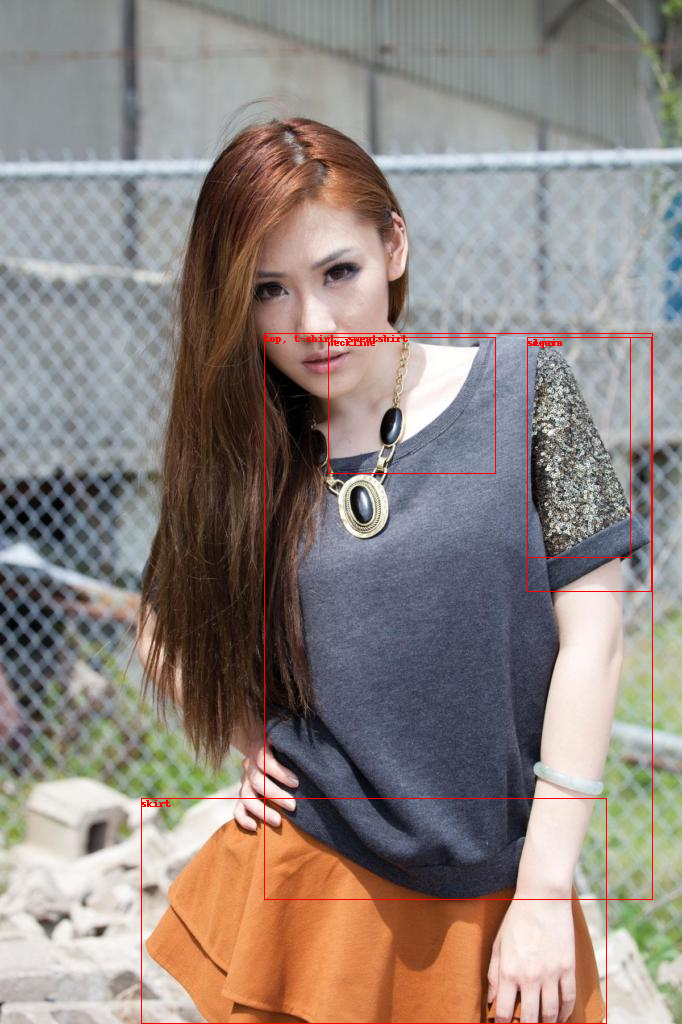

In [8]:
dd.show()

### Numbers

In [9]:
dd.n_images

46781

In [10]:
dd.n_bbox

342182

As mentionned earlier, there is no 'test' dataset here:

In [11]:
dd.splits

['train', 'val']

In [12]:
dd.split_proportions

,train,val,test
0,0.975246,0.024754,0.0


We also see that >97.5% of the images belong to the training dataset.

### Categories

There are 46 categories in this dataset, we can get the full list:

In [13]:
dd.n_categories

46

In [14]:
dd.category_names

['shirt, blouse',
 'top, t-shirt, sweatshirt',
 'sweater',
 'cardigan',
 'jacket',
 'vest',
 'pants',
 'shorts',
 'skirt',
 'coat',
 'dress',
 'jumpsuit',
 'cape',
 'glasses',
 'hat',
 'headband, head covering, hair accessory',
 'tie',
 'glove',
 'watch',
 'belt',
 'leg warmer',
 'tights, stockings',
 'sock',
 'shoe',
 'bag, wallet',
 'scarf',
 'umbrella',
 'hood',
 'collar',
 'lapel',
 'epaulette',
 'sleeve',
 'pocket',
 'neckline',
 'buckle',
 'zipper',
 'applique',
 'bead',
 'bow',
 'flower',
 'fringe',
 'ribbon',
 'rivet',
 'ruffle',
 'sequin',
 'tassel']

Let's also show the categories with their ids:

In [15]:
dd.categories

,category
category_id,
0,"shirt, blouse"
1,"top, t-shirt, sweatshirt"
2,sweater
3,cardigan
4,jacket
5,vest
6,pants
7,shorts
8,skirt


## Upload to the Hub

We can now upload the dataset to the Hugging Face Hub:

In [16]:
dd.to_hub(dataset_name='fashionpedia', repo_name='detection-datasets')

Pushing split train to the Hub.


  0%|          | 0/7 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/7 [00:00<?, ?it/s]

/Users/jeromeblin/self/blinjrm/detection-datasets/.venv/lib/python3.8/site-packages/huggingface_hub/hf_api.py:2165: FutureWarning: `identical_ok` has no effect and is deprecated. It will be removed in 0.11.0.
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/7 [00:00<?, ?it/s]

Pushing split val to the Hub.


  0%|          | 0/2 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]